# Inicio

El objetivo del proyecto es predecir aquellos clientes con mayor propensión a abrir un mail de marketing sobre la adquisición de tarjetas de crédito por parte de una entidad bancaria

Para eso se utilizarán datos históricos para el entrenamiento

Negocio nos dice que tuvo un equipo de científicos previamente que obtuvo unas métricas que pueden verse a continuación. Sugiere que deberíamos intentar conseguir, al menos, algo similar.

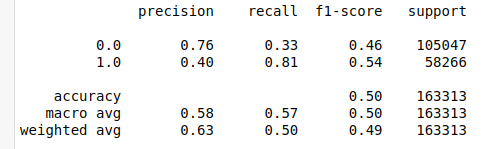

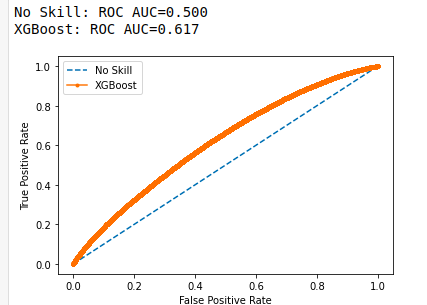

# Análisis Exploratorio de Datos

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb
from datetime import datetime
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
def calculate_roc(testy,lr_probs):
    # calculate scores
    ns_probs = [0 for _ in range(len(testy))]
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

## Carga del Dataset

In [4]:
df = pd.read_csv('./DatasetModulo2.csv')

In [5]:
pd.set_option('display.max_columns',500)

## Análisis Inicial del Dataset y Target

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494887 entries, 0 to 494886
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   FechaSaldos                    494887 non-null  object 
 1   periodo_cli                    494887 non-null  int64  
 2   periodo                        494887 non-null  int64  
 3   cant_productos                 494887 non-null  int64  
 4   cant_PF                        494887 non-null  int64  
 5   cant_TC                        494887 non-null  int64  
 6   cant_PP                        494887 non-null  int64  
 7   FechaUltMovCA                  468164 non-null  object 
 8   cant_seguros                   494887 non-null  int64  
 9   importe_consumos               494887 non-null  int64  
 10  Edad                           494887 non-null  int64  
 11  Sexo                           494887 non-null  object 
 12  SaldoPromedioCAPesos          

In [7]:
df.target.value_counts(normalize=True)

0.0    0.993797
1.0    0.006203
Name: target, dtype: float64

In [8]:
df.target2.value_counts(normalize=True)

0.0    0.643668
1.0    0.356332
Name: target2, dtype: float64

## Análisis de Valores Nulos, Faltantes, erróneos

In [9]:
df.Sexo.value_counts(dropna=False)

F    277632
M    215313
       1942
Name: Sexo, dtype: int64

In [10]:
df.Sexo = df.Sexo.str.replace(' ','Na')

In [11]:
[col for col in df.columns if df[col].isna().any()==True]

['FechaUltMovCA',
 'FechaVinculacion',
 'SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'TotalConsumoTD_ant_1',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'TotalConsumoTD_ant_2',
 'score_deuda']

In [13]:
df.CategoriaProducto.value_counts()

14    256073
10    103374
12     87834
28     15771
19      9956
18      7610
3       3781
15      2331
9       1456
26      1367
27      1363
22      1361
7        729
16       551
6        349
23       213
13       153
25       148
20       145
17       113
5         66
11        54
1         39
4         17
24        12
8          8
2          6
21         5
0          2
Name: CategoriaProducto, dtype: int64

In [11]:
df.score_deuda.fillna(0,inplace=True)

In [12]:
df.CategoriaProducto.value_counts(normalize=True,dropna=False)

14    0.517437
10    0.208884
12    0.177483
28    0.031868
19    0.020118
18    0.015377
3     0.007640
15    0.004710
9     0.002942
26    0.002762
27    0.002754
22    0.002750
7     0.001473
16    0.001113
6     0.000705
23    0.000430
13    0.000309
25    0.000299
20    0.000293
17    0.000228
5     0.000133
11    0.000109
1     0.000079
4     0.000034
24    0.000024
8     0.000016
2     0.000012
21    0.000010
0     0.000004
Name: CategoriaProducto, dtype: float64

In [13]:
to_keep = df.CategoriaProducto.value_counts(normalize=True,dropna=False)[:3].index

In [14]:
to_keep

Int64Index([14, 10, 12], dtype='int64')

In [15]:
df.CategoriaProducto.fillna('OTH',inplace=True)

In [16]:
df.CategoriaProducto = df.CategoriaProducto.apply(lambda x:'OTH' if x not in to_keep else x)

In [17]:
df.CategoriaProducto.value_counts()

14     256073
10     103374
12      87834
OTH     47606
Name: CategoriaProducto, dtype: int64

In [18]:
df.FechaSaldos = pd.to_datetime(df.FechaSaldos)

In [19]:
df.FechaUltMovCA = pd.to_datetime(df.FechaUltMovCA)

In [20]:
df.FechaVinculacion = pd.to_datetime(df.FechaVinculacion)

In [21]:
df[df.FechaVinculacion.isna()]['target2'].value_counts()

0.0    46403
1.0    32861
Name: target2, dtype: int64

In [22]:
df[df.FechaUltMovCA.isna()]['target2'].value_counts()

0.0    15337
1.0    11386
Name: target2, dtype: int64

In [23]:
df.target2.value_counts()

0.0    318543
1.0    176344
Name: target2, dtype: int64

In [24]:
df.FechaUltMovCA.mode()

0   2019-12-05
dtype: datetime64[ns]

In [25]:
df['FechaUltMovCA'].describe()

count                  468164
unique                    971
top       2019-12-05 00:00:00
freq                   101996
first     2004-04-19 00:00:00
last      2020-02-06 00:00:00
Name: FechaUltMovCA, dtype: object

In [26]:
df.loc[df.FechaUltMovCA.isna(),'FechaUltMovCA']=pd.to_datetime('2019-09-20')

In [27]:
(df.FechaVinculacion.dt.year - datetime.now().year)

0        -3.0
1        -5.0
2         NaN
3         NaN
4         NaN
         ... 
494882   -6.0
494883   -4.0
494884   -2.0
494885   -2.0
494886   -1.0
Name: FechaVinculacion, Length: 494887, dtype: float64

In [28]:
df['antiguedad']=(df.FechaVinculacion.dt.year - datetime.now().year)*-1

In [29]:
df.loc[df['antiguedad'].isna(),'antiguedad']=df.antiguedad.mean()

In [30]:
df.drop(columns='FechaVinculacion',inplace=True)

In [31]:
[col for col in df.columns if df[col].isna().any()==True]

['SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'TotalConsumoTD_ant_1',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'TotalConsumoTD_ant_2']

In [32]:
df.fillna(0,inplace=True)

In [33]:
df.drop(columns='target',inplace=True)

## Chequeo outliers

In [34]:
for col in df.select_dtypes('number').columns:
    print(col,sum(df[col]>df[col].quantile(0.95)))

periodo_cli 14014
periodo 14014
cant_productos 14527
cant_PF 12685
cant_TC 10671
cant_PP 10084
cant_seguros 23866
importe_consumos 355
Edad 24146
SaldoPromedioCAPesos 24745
SaldoPromedioCADolares 24745
SaldoPromedioCCAcreedor 18656
TotalConsumoTD 24745
TipoCuentaAcredHab 0
cuotas_faltantes_1 24386
cant_PF_ant_1 11187
cant_TC_ant_1 10503
cant_PP_ant_1 10318
SaldoPromedioCAPesos_ant_1 24745
SaldoPromedioCADolares_ant_1 24745
SaldoPromedioCCAcreedor_ant_1 18549
importe_consumos_ant_1 328
TotalConsumoTD_ant_1 24745
cuotas_faltantes 24676
cant_PF_ant_2 9425
cant_TC_ant_2 10371
cant_PP_ant_2 9729
SaldoPromedioCAPesos_ant_2 24745
SaldoPromedioCADolares_ant_2 24745
SaldoPromedioCCAcreedor_ant_2 18504
importe_consumos_ant_2 323
TotalConsumoTD_ant_2 24745
cuotas_faltantes_2 24685
score_deuda 10107
target2 0
antiguedad 16655


## Estudio de Distribución individual de los datos

In [35]:
all(df.periodo == df.periodo_cli)

True

In [36]:
df.drop(columns='periodo',inplace=True)

In [37]:
df[df.Edad<=18]['target2'].value_counts()

0.0    911
1.0    695
Name: target2, dtype: int64

In [38]:
df=df[df.Edad>18].copy()

In [39]:
df.shape

(493281, 39)

In [40]:
[col for col in df.columns if df[col].nunique()==1]

['TipoCuentaAcredHab']

In [41]:
df.drop(columns=[col for col in df.columns if df[col].nunique()==1],inplace=True)

In [42]:
df.drop(columns=['FechaSaldos','periodo_cli'],inplace=True)

### Uds ya tienen claro esto :)

## Ingeniería de Variables

### Variables Continuas

#### Calcular media, std, min, max, suma. Esto es por fila entre los períodos, es decir, por ejemplo, cálculo de esos datos para los montos que incluyen _1 y _2. Dejarlas como columnas adicionales.

In [43]:
for col in df.columns:
    if col+'_ant_1' in df.columns:
        print("Calculating %s" % col)
        df[col+'_mean']=df[[col,col+'_ant_1',col+'_ant_2']].mean(axis=1)
        df[col+'_std']=df[[col,col+'_ant_1',col+'_ant_2']].std(axis=1)
        df[col+'_min']=df[[col,col+'_ant_1',col+'_ant_2']].min(axis=1)
        df[col+'_max']=df[[col,col+'_ant_1',col+'_ant_2']].max(axis=1)
        df[col+'_TasaNew']=df[col].div(df[col+'_ant_1'])
        df[col+'_TasaOld']=df[col].div(df[col+'_ant_2'])

Calculating cant_PF
Calculating cant_TC
Calculating cant_PP
Calculating importe_consumos
Calculating SaldoPromedioCAPesos
Calculating SaldoPromedioCADolares
Calculating SaldoPromedioCCAcreedor
Calculating TotalConsumoTD


In [44]:
df.shape

(493281, 84)

In [45]:
df.columns

Index(['cant_productos', 'cant_PF', 'cant_TC', 'cant_PP', 'FechaUltMovCA',
       'cant_seguros', 'importe_consumos', 'Edad', 'Sexo',
       'SaldoPromedioCAPesos', 'SaldoPromedioCADolares',
       'SaldoPromedioCCAcreedor', 'TotalConsumoTD', 'CategoriaProducto',
       'cuotas_faltantes_1', 'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target2', 'antiguedad', 'cant_PF_mean', 'cant_PF_std',
       'cant_PF_min', 'cant_PF_max', 'cant_PF_TasaNew', 'cant_PF_TasaOld',
       'cant_TC_mean', 'cant_TC_std', 'cant_TC_min', 'cant_TC_max',
       'ca

### Variables Categóricas

#### Transformar variables Categóricas Nominales a matríz de unos y ceros

In [46]:
df.select_dtypes(exclude='number')

,FechaUltMovCA,Sexo,CategoriaProducto
0,2019-12-02,M,12
1,2019-12-04,F,12
2,2019-12-05,F,12
3,2019-12-05,F,12
4,2019-12-05,F,14
...,...,...,...
494804,2020-02-06,Na,OTH
494845,2020-02-06,Na,OTH
494872,2020-02-06,Na,OTH
494873,2019-09-23,Na,OTH


In [47]:
df = pd.concat([df,pd.get_dummies(df.Sexo),pd.get_dummies(df.CategoriaProducto)],axis=1)

In [48]:
df.drop(columns=['Sexo','CategoriaProducto'],inplace=True)

In [49]:
(df.FechaUltMovCA.dt.date - datetime(2020,2,10).date()).dt.days

0         -70
1         -68
2         -67
3         -67
4         -67
         ... 
494804     -4
494845     -4
494872     -4
494873   -140
494881     -4
Name: FechaUltMovCA, Length: 493281, dtype: int64

In [50]:
df['DiasDesdeMov']=((df.FechaUltMovCA.dt.date - datetime(2020,2,10).date())*-1).dt.days

In [51]:
df['DiasDesdeMov'].fillna(-999,inplace=True)

#### Transformar variables Categóricas Ordinales con Label Encoding

In [52]:
df.drop(columns=['FechaUltMovCA'],inplace=True)

In [53]:
df.fillna(0,inplace=True)

# Modelado

## Trabajar las variables para ingresar al modelo. Seleccionar método de escalado (ver StandardScaler, MinMaxScaler, etc) y elegir uno o probar varios

In [54]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

# Sampleo para poder trabajar más rápido...

In [55]:
df = df.sample(frac=0.02)

In [56]:
y=df.target2

In [57]:
df.describe()

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes_1,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,SaldoPromedioCAPesos_ant_1,SaldoPromedioCADolares_ant_1,SaldoPromedioCCAcreedor_ant_1,importe_consumos_ant_1,TotalConsumoTD_ant_1,cuotas_faltantes,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,target2,antiguedad,cant_PF_mean,cant_PF_std,cant_PF_min,cant_PF_max,cant_PF_TasaNew,cant_PF_TasaOld,cant_TC_mean,cant_TC_std,cant_TC_min,cant_TC_max,cant_TC_TasaNew,cant_TC_TasaOld,cant_PP_mean,cant_PP_std,cant_PP_min,cant_PP_max,cant_PP_TasaNew,cant_PP_TasaOld,importe_consumos_mean,importe_consumos_std,importe_consumos_min,importe_consumos_max,importe_consumos_TasaNew,importe_consumos_TasaOld,SaldoPromedioCAPesos_mean,SaldoPromedioCAPesos_std,SaldoPromedioCAPesos_min,SaldoPromedioCAPesos_max,SaldoPromedioCAPesos_TasaNew,SaldoPromedioCAPesos_TasaOld,SaldoPromedioCADolares_mean,SaldoPromedioCADolares_std,SaldoPromedioCADolares_min,SaldoPromedioCADolares_max,SaldoPromedioCADolares_TasaNew,SaldoPromedioCADolares_TasaOld,SaldoPromedioCCAcreedor_mean,SaldoPromedioCCAcreedor_std,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld,F,M,Na,10,12,14,OTH,DiasDesdeMov
count,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9.866000e+03,9866.000000,9.866000e+03,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9.866000e+03,9866.000000,9.866000e+03,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9.866000e+03,9866.000000,9.866000e+03,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.0,9866.0,9866.000000,9866.000000,9866.000000,9866.000000,9866.0,9866.0,9866.000000,9866.000000,9866.000000,9866.000000,9866.0,9866.0,9866.000000,9866.000000,9866.000000,9866.000000,9866.0,9866.0,9.866000e+03,9.866000e+03,9.866000e+03,9.866000e+03,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.0,9866.0,9.866000e+03,9866.000000,9.866000e+03,9.866000e+03,9866.0,9866.0,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000
mean,3.432698,0.137644,1.328198,0.200081,0.420839,11.972431,49.048145,3.956440e+04,608.940464,7.298899e+02,5167.519092,8.744375,0.125583,1.323231,0.202716,3.457204e+04,641.263073,7.745232e+02,9.304683,4381.123163,8.623252,0.105108,1.312082,0.199878,3.330202e+04,647.327838,8.886076e+02,11.181837,4121.340324,8.842591,0.761099,0.348368,8.159451,0.122779,0.061096,0.071255,0.180114,inf,inf,1.321170,0.024718,1.298500,1.341476,inf,inf,0.200892,0.016978,0.186296,0.215893,inf,inf,10.819650,3.446485,8.508615,14.700182,inf,inf,3.581282e+04,1.058292e+04,2.653389e+04,4.658989e+04,inf,inf,632.510458,155.414194,497.487578,786.443169,inf,inf,7.976736e+02,313.509934,5.349926e+02,1.127677e+03,inf,inf,4556.660860,2304.668621,2565.684494,6915.639357,inf,inf,0.556659,0.442023,0.001318,0.213764,0.170991,0.522806,0.092439,185.311271
std,1.809582,0.614991,1.190148,0.466304,0.834305,468.884888,17.189225,1.325263e+05,4186.585510,1.626604e+04,10191.546413,27.658641,0.589432,1.188909,0.466470,1.289695e+05,4593.908708,1.661851e+04,327.008319,8669.240163,27.470024,0.479060,1.180948,0.459383,1.230279e+05,4263.019811,2.278554e+04,399.819078,8591.046231,27.857360,0.559298,0.476477,5.090702,0.513395,0.280619,0.388234,0.724836,NaN,NaN,1.181806,0.129448,1.179136,1.191394,NaN,NaN,0.456406,0.101429,0.441578,0.488712,NaN,NaN,384.009040,148.717758,303.508049,536

In [58]:
df.columns = df.columns.astype(str)

In [59]:
colstoexclude=['target2']+[col for col in df.columns if 'Dolares' in col]

In [60]:
colstoexclude

['target2',
 'SaldoPromedioCADolares',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCADolares_mean',
 'SaldoPromedioCADolares_std',
 'SaldoPromedioCADolares_min',
 'SaldoPromedioCADolares_max',
 'SaldoPromedioCADolares_TasaNew',
 'SaldoPromedioCADolares_TasaOld']

In [61]:
X=df[[col for col in df.columns if col not in colstoexclude]]

In [62]:
X

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes_1,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,SaldoPromedioCAPesos_ant_1,SaldoPromedioCCAcreedor_ant_1,importe_consumos_ant_1,TotalConsumoTD_ant_1,cuotas_faltantes,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,antiguedad,cant_PF_mean,cant_PF_std,cant_PF_min,cant_PF_max,cant_PF_TasaNew,cant_PF_TasaOld,cant_TC_mean,cant_TC_std,cant_TC_min,cant_TC_max,cant_TC_TasaNew,cant_TC_TasaOld,cant_PP_mean,cant_PP_std,cant_PP_min,cant_PP_max,cant_PP_TasaNew,cant_PP_TasaOld,importe_consumos_mean,importe_consumos_std,importe_consumos_min,importe_consumos_max,importe_consumos_TasaNew,importe_consumos_TasaOld,SaldoPromedioCAPesos_mean,SaldoPromedioCAPesos_std,SaldoPromedioCAPesos_min,SaldoPromedioCAPesos_max,SaldoPromedioCAPesos_TasaNew,SaldoPromedioCAPesos_TasaOld,SaldoPromedioCCAcreedor_mean,SaldoPromedioCCAcreedor_std,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld,F,M,Na,10,12,14,OTH,DiasDesdeMov
149040,3,0,1,0,0,0,35,1948.21,0.0,0.00,0,0,1,0,1947.86,0.0,0,0.00,0,0,1,0,1947.52,0.0,0,0.00,0,0.0,3.0,0.0,0.0,0,0,0.0,0.0,1.0,0.0,1,1,1.0,1.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,1947.863333,0.345012,1947.52,1948.21,1.000180,1.000354,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,1,0,0,0,0,1,0,654
420735,3,0,1,0,1,0,28,68878.45,0.0,15660.55,0,0,1,0,27544.13,0.0,0,3298.05,0,0,1,0,23179.48,0.0,0,8992.40,0,1.0,7.0,0.0,0.0,0,0,0.0,0.0,1.0,0.0,1,1,1.0,1.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,39867.353333,25218.948030,23179.48,68878.45,2.500658,2.971527,0.0,0.0,0.0,0.0,0.0,0.0,9317.000000,6187.638922,3298.05,15660.55,4.748427,1.741532,0,1,0,1,0,0,0,357
222010,1,0,0,0,0,0,88,735.06,0.0,1429.16,0,0,0,0,713.64,0.0,0,11050.49,0,0,0,0,737.80,0.0,0,14115.21,0,0.0,16.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,728.833333,13.228943,713.64,737.80,1.030015,0.996286,0.0,0.0,0.0,0.0,0.0,0.0,8864.953333,6619.395293,1429.16,14115.21,0.129330,0.101250,1,0,0,0,1,0,0,73
118031,4,0,1,0,4,0,40,88319.49,0.0,9213.53,0,0,1,0,57825.43,0.0,0,1000.01,0,0,1,0,84017.40,0.0,0,6160.89,0,1.0,12.0,0.0,0.0,0,0,0.0,0.0,1.0,0.0,1,1,1.0,1.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,76720.773333,16504.620394,57825.43,88319.49,1.527347,1.051205,0.0,0.0,0.0,0.0,0.0,0.0,5458.143333,4151.610212,1000.01,9213.53,9.213438,1.495487,1,0,0,0,0,1,0,67
111784,3,0,2,0,0,0,41,147489.18,0.0,0.00,0,0,2,0,198700.77,0.0,0,0.00,0,0,2,0,182285.38,0.0,0,0.00,0,1.0,16.0,0.0,0.0,0,0,0.0,0.0,2.0,0.0,2,2,1.0,1.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,176158.443333,26149.784937,147489.18,198700.77,0.742268,0.809111,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,1,0,0,1,0,0,0,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251916,3,0,1,0,0,0,66,8054.21,0.0,0.00,0,0,1,0,4979.36,0.0,0,0.00,0,0,1,0,2179.09,0.0,0,0.00,0,0.0,3.0,0.0,0.0,0,0,0.0,0.0,1.0,0.0,1,1,1.0,1.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,5070.886667,2938.629205,2179.09,8054.21,1.617519,3.696135,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,1,0,0,0,1,0,0,245
290236,1,0,0,0,0,0,93,353.73,0.0,0.00,0,0,0,0,353.69,0.0,0,0.00,0,0,0,0,353.65,0.0,0,0.00,0,0.0,13.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,353.690000,0.040000,353.65,353.73,1.000113,1.000226,0.0,0.0,0.0,0.0,0.0,

In [63]:
X = X.replace([np.inf, -np.inf], 0)

## Utilizando RobustScaler

In [64]:
from sklearn.preprocessing import RobustScaler

In [66]:
RobustScaler

sklearn.preprocessing._data.RobustScaler

In [71]:
scaler = RobustScaler()

In [72]:
X_scaled = scaler.fit_transform(X)

In [73]:
X_scaled=pd.DataFrame(X_scaled)
X_scaled.columns = X.columns

In [74]:
X_scaled

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes_1,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,SaldoPromedioCAPesos_ant_1,SaldoPromedioCCAcreedor_ant_1,importe_consumos_ant_1,TotalConsumoTD_ant_1,cuotas_faltantes,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,antiguedad,cant_PF_mean,cant_PF_std,cant_PF_min,cant_PF_max,cant_PF_TasaNew,cant_PF_TasaOld,cant_TC_mean,cant_TC_std,cant_TC_min,cant_TC_max,cant_TC_TasaNew,cant_TC_TasaOld,cant_PP_mean,cant_PP_std,cant_PP_min,cant_PP_max,cant_PP_TasaNew,cant_PP_TasaOld,importe_consumos_mean,importe_consumos_std,importe_consumos_min,importe_consumos_max,importe_consumos_TasaNew,importe_consumos_TasaOld,SaldoPromedioCAPesos_mean,SaldoPromedioCAPesos_std,SaldoPromedioCAPesos_min,SaldoPromedioCAPesos_max,SaldoPromedioCAPesos_TasaNew,SaldoPromedioCAPesos_TasaOld,SaldoPromedioCCAcreedor_mean,SaldoPromedioCCAcreedor_std,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld,F,M,Na,10,12,14,OTH,DiasDesdeMov
0,0.0,0.0,0.0,0.0,0.0,0.0,-0.44,-0.346602,0.0,0.000000,0.0,0.0,0.0,0.0,-0.318542,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-0.312145,0.0,0.0,0.000000,0.0,-1.0,-0.746960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.351008,-0.402929,-0.280803,-0.378763,-0.094416,-0.103570,0.0,0.0,0.0,0.0,0.0,0.0,-0.057168,-0.134246,0.000000,-0.094824,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.932836
1,0.0,0.0,0.0,0.0,1.0,0.0,-0.72,1.620797,0.0,2.442430,0.0,0.0,0.0,0.0,0.570557,0.0,0.0,0.616321,0.0,0.0,0.0,0.0,0.469000,0.0,0.0,1.790373,0.0,0.0,-0.175531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.902467,2.338846,0.705849,1.284556,1.618932,1.678397,0.0,0.0,0.0,0.0,0.0,0.0,1.422928,1.950904,1.263649,1.518430,4.977264,1.779431,-1.0,1.0,0.0,1.0,0.0,-1.0,0.0,0.824627
2,-1.0,0.0,-1.0,0.0,0.0,0.0,1.68,-0.382262,0.0,0.222893,0.0,0.0,-1.0,0.0,-0.361413,0.0,0.0,2.065054,0.0,0.0,-1.0,0.0,-0.356652,0.0,0.0,2.810317,0.0,-1.0,1.110183,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.391304,-0.401528,-0.338142,-0.408844,-0.060348,-0.107247,0.0,0.0,0.0,0.0,0.0,0.0,1.351116,2.096400,0.547583,1.359239,0.135563,0.103453,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,-0.235075
3,0.5,0.0,0.0,0.0,4.0,0.0,-0.24,2.192262,0.0,1.436948,0.0,0.0,0.0,0.0,1.622392,0.0,0.0,0.186876,0.0,0.0,0.0,0.0,2.707287,0.0,0.0,1.226624,0.0,0.0,0.538754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.120701,1.391422,2.315850,1.767696,0.507539,-0.057600,0.0,0.0,0.0,0.0,0.0,0.0,0.809911,1.264790,0.383154,0.854298,9.657453,1.528031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.257463
4,0.0,0.0,1.0,0.0,0.0,0.0,-0.20,3.931542,0.0,0.000000,0.0,0.0,1.0,0.0,6.515763,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,6.322664,0.0,0.0,0.000000,0.0,0.0,1.110183,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.407734,2.440047,6.482536,4.510841,-0.388917,-0.276456,0.0,0.0,0.0,0.0,0.0,0.0,-0.057168,-0.134246,0.000000,-0.094824,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,-0.246269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9861,0.0,0.0,0.0,0.0,0.0,0.0,0.80,-0.167118,0.0,0.000000,0.0,0.0,0.0,0.0,-0.213241,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-0.303626,0.0,0.0,0.000000,0.0,-1.0,-0.746960,0.0

In [75]:
X = X_scaled.copy()

In [76]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [77]:
X_train

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes_1,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,SaldoPromedioCAPesos_ant_1,SaldoPromedioCCAcreedor_ant_1,importe_consumos_ant_1,TotalConsumoTD_ant_1,cuotas_faltantes,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,antiguedad,cant_PF_mean,cant_PF_std,cant_PF_min,cant_PF_max,cant_PF_TasaNew,cant_PF_TasaOld,cant_TC_mean,cant_TC_std,cant_TC_min,cant_TC_max,cant_TC_TasaNew,cant_TC_TasaOld,cant_PP_mean,cant_PP_std,cant_PP_min,cant_PP_max,cant_PP_TasaNew,cant_PP_TasaOld,importe_consumos_mean,importe_consumos_std,importe_consumos_min,importe_consumos_max,importe_consumos_TasaNew,importe_consumos_TasaOld,SaldoPromedioCAPesos_mean,SaldoPromedioCAPesos_std,SaldoPromedioCAPesos_min,SaldoPromedioCAPesos_max,SaldoPromedioCAPesos_TasaNew,SaldoPromedioCAPesos_TasaOld,SaldoPromedioCCAcreedor_mean,SaldoPromedioCCAcreedor_std,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld,F,M,Na,10,12,14,OTH,DiasDesdeMov
5639,0.0,0.0,0.0,0.0,0.0,0.0,-0.32,0.498733,0.0,0.000000,0.0,0.0,0.0,0.0,0.082840,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.501835,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336978,0.540308,0.256193,0.335918,1.360104,0.145258,0.0,0.0,0.0,0.0,0.0,0.0,-0.057168,-0.134246,0.000000,-0.094824,0.000000,0.000000,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.257463
5521,0.0,0.0,0.0,1.0,0.0,0.0,-0.16,-0.255755,0.0,0.000000,0.0,0.0,0.0,1.0,-0.206102,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,-0.013069,0.0,0.0,0.685456,0.0,0.0,-0.746960,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.191714,-0.091230,-0.137152,-0.176761,-0.126801,-0.555853,0.0,0.0,0.0,0.0,0.0,0.0,0.125140,0.535582,0.000000,0.259832,0.000000,0.000000,-1.0,1.0,0.0,1.0,0.0,-1.0,0.0,0.835821
1076,-0.5,0.0,1.0,0.0,2.0,0.0,-0.04,-0.403869,0.0,0.000000,0.0,0.0,1.0,0.0,-0.386202,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,-0.383797,0.0,0.0,0.000000,0.0,-1.0,0.110183,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.415397,-0.402967,-0.371305,-0.427179,-1.236489,-1.007903,0.0,0.0,0.0,0.0,0.0,0.0,-0.057168,-0.134246,0.000000,-0.094824,0.000000,0.000000,-1.0,1.0,0.0,0.0,0.0,-1.0,1.0,0.026119
8184,0.0,0.0,0.0,0.0,0.0,0.0,-0.28,-0.236318,0.0,0.108984,0.0,0.0,0.0,0.0,-0.367938,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-0.383797,0.0,0.0,0.000000,0.0,-1.0,-1.032674,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.346796,-0.060486,-0.371305,-0.285525,11.141876,-1.007903,0.0,0.0,0.0,0.0,0.0,0.0,-0.020165,0.001710,0.000000,-0.022839,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.026119
3523,1.5,0.0,2.0,1.0,0.0,0.0,0.32,0.352564,0.0,4.516624,20.0,0.0,2.0,1.0,0.306907,0.0,0.0,0.778969,19.0,0.0,2.0,1.0,0.016870,0.0,0.0,1.765277,21.0,0.0,0.967326,0.000000,0.000000,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208020,0.410472,0.134770,0.212340,0.236122,1.128260,0.0,0.0,0.0,0.0,0.0,0.0,2.166591,4.303346,1.597127,2.888461,7.282312,3.337365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.0,0.0,0.0,0.0,0.0,0.0,-0.20,5.882186,0.0,0.000000,0.0,0.0,0.0,0.0,1.156058,0.0,0.0,0.000000,

In [78]:
y_train.shape

(7399,)

In [79]:
X_test.shape

(2467, 79)

In [80]:
y_test.shape

(2467,)

## Utilizando MinMax Scaler

In [81]:
from sklearn.preprocessing import MinMaxScaler

In [94]:
MinMaxScaler

<function sklearn.base.BaseEstimator.get_params(self, deep=True)>

In [83]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled)
X_scaled.columns = X.columns

Llevamos la distribucion entre 0 y 1

In [96]:
scaler.get_params()

{'copy': True, 'feature_range': (0, 1)}

In [84]:
X_scaled

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes_1,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,SaldoPromedioCAPesos_ant_1,SaldoPromedioCCAcreedor_ant_1,importe_consumos_ant_1,TotalConsumoTD_ant_1,cuotas_faltantes,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,antiguedad,cant_PF_mean,cant_PF_std,cant_PF_min,cant_PF_max,cant_PF_TasaNew,cant_PF_TasaOld,cant_TC_mean,cant_TC_std,cant_TC_min,cant_TC_max,cant_TC_TasaNew,cant_TC_TasaOld,cant_PP_mean,cant_PP_std,cant_PP_min,cant_PP_max,cant_PP_TasaNew,cant_PP_TasaOld,importe_consumos_mean,importe_consumos_std,importe_consumos_min,importe_consumos_max,importe_consumos_TasaNew,importe_consumos_TasaOld,SaldoPromedioCAPesos_mean,SaldoPromedioCAPesos_std,SaldoPromedioCAPesos_min,SaldoPromedioCAPesos_max,SaldoPromedioCAPesos_TasaNew,SaldoPromedioCAPesos_TasaOld,SaldoPromedioCCAcreedor_mean,SaldoPromedioCCAcreedor_std,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld,F,M,Na,10,12,14,OTH,DiasDesdeMov
0,0.1250,0.0,0.071429,0.0,0.0,0.0,0.16,0.000262,0.0,0.000000,0.000000,0.0,0.071429,0.0,0.000268,0.0,0.0,0.000000,0.000000,0.0,0.071429,0.0,0.000276,0.0,0.0,0.000000,0.000000,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.071429,0.071429,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000269,3.057432e-07,0.000276,0.000262,5.598512e-07,1.231888e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.200123
1,0.1250,0.0,0.071429,0.0,0.1,0.0,0.09,0.009247,0.0,0.074931,0.000000,0.0,0.071429,0.0,0.003795,0.0,0.0,0.023948,0.000000,0.0,0.071429,0.0,0.003287,0.0,0.0,0.026312,0.000000,0.2,0.233333,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.071429,0.071429,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005497,2.234856e-02,0.003287,0.009247,1.399745e-06,3.659291e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.063849,0.035575,0.035764,0.045823,0.017779,0.000439,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.108682
2,0.0000,0.0,0.000000,0.0,0.0,0.0,0.69,0.000099,0.0,0.006838,0.000000,0.0,0.000000,0.0,0.000098,0.0,0.0,0.080242,0.000000,0.0,0.000000,0.0,0.000105,0.0,0.0,0.041301,0.000000,0.0,0.533333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000100,1.172324e-05,0.000101,0.000099,5.765516e-07,1.226878e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.060751,0.038057,0.015498,0.041301,0.000484,0.000026,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.021244
3,0.1875,0.0,0.071429,0.0,0.4,0.0,0.21,0.011857,0.0,0.044084,0.000000,0.0,0.071429,0.0,0.007966,0.0,0.0,0.007261,0.000000,0.0,0.071429,0.0,0.011915,0.0,0.0,0.018027,0.000000,0.2,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.071429,0.071429,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010578,1.462608e-02,0.008200,0.011857,8.549334e-07,1.294508e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.037404,0.023869,0.010844,0.026959,0.034496,0.000377,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.019397
4,0.1250,0.0,0.142857,0.0,0.0,0.0,0.22,0.019800,0.0,0.000000,0.000000,0.0,0.142857,0.0,0.027374,0.0,0.0,0.000000,0.000000,0.0,0.142857,0.0,0.025850,0.0,0.0,0.000000,0.000000,0.2,0.533333,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.142857,0.142857,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024287,2.317345e-02,0.020916,0.026675,4.154849e-07,9.963814e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.020320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [85]:
X = X_scaled.copy()
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [86]:
X_train

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes_1,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,SaldoPromedioCAPesos_ant_1,SaldoPromedioCCAcreedor_ant_1,importe_consumos_ant_1,TotalConsumoTD_ant_1,cuotas_faltantes,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,antiguedad,cant_PF_mean,cant_PF_std,cant_PF_min,cant_PF_max,cant_PF_TasaNew,cant_PF_TasaOld,cant_TC_mean,cant_TC_std,cant_TC_min,cant_TC_max,cant_TC_TasaNew,cant_TC_TasaOld,cant_PP_mean,cant_PP_std,cant_PP_min,cant_PP_max,cant_PP_TasaNew,cant_PP_TasaOld,importe_consumos_mean,importe_consumos_std,importe_consumos_min,importe_consumos_max,importe_consumos_TasaNew,importe_consumos_TasaOld,SaldoPromedioCAPesos_mean,SaldoPromedioCAPesos_std,SaldoPromedioCAPesos_min,SaldoPromedioCAPesos_max,SaldoPromedioCAPesos_TasaNew,SaldoPromedioCAPesos_TasaOld,SaldoPromedioCCAcreedor_mean,SaldoPromedioCCAcreedor_std,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld,F,M,Na,10,12,14,OTH,DiasDesdeMov
2939,0.0625,0.0,0.000000,0.25,0.0,0.0,0.26,0.000026,0.0,0.000000,0.113553,0.0,0.000000,0.25,0.000099,0.0,0.0,0.017565,0.111524,0.0,0.000000,0.333333,0.000069,0.0,0.0,0.000000,0.115523,0.2,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.272727,0.0,0.333333,0.25,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.000064,0.000230,0.000028,0.000096,1.537175e-07,4.966272e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.005526,0.008030,0.000000,0.007078,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.023399
3348,0.0625,0.0,0.071429,0.00,0.0,0.0,0.11,0.003259,0.0,0.182348,0.000000,0.0,0.071429,0.00,0.001611,0.0,0.0,0.259469,0.000000,0.0,0.071429,0.000000,0.002712,0.0,0.0,0.084736,0.000000,0.2,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.00,0.071429,0.071429,0.333333,0.333333,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.002532,0.005606,0.001658,0.003259,1.162208e-06,1.563485e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.234833,0.027299,0.314036,0.111513,0.003993,0.000332,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.043103
3576,0.1875,0.0,0.142857,0.00,0.0,0.0,0.27,0.002808,0.0,0.131192,0.000000,0.0,0.142857,0.00,0.002745,0.0,0.0,0.231930,0.000000,0.0,0.142857,0.000000,0.001899,0.0,0.0,0.055993,0.000000,0.2,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.00,0.142857,0.142857,0.333333,0.333333,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.002492,0.003624,0.001899,0.002808,5.876811e-07,1.923636e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.179307,0.037333,0.207511,0.093457,0.003214,0.000361,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.054187
9112,0.3125,0.0,0.214286,0.25,0.1,0.0,0.18,0.005152,0.0,0.000000,0.062271,0.0,0.214286,0.25,0.003384,0.0,0.0,0.000000,0.059480,0.0,0.214286,0.333333,0.002203,0.0,0.0,0.000000,0.061372,0.2,0.466667,0.0,0.0,0.0,0.0,0.0,0.0,0.214286,0.00,0.214286,0.214286,0.333333,0.333333,0.272727,0.0,0.333333,0.25,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.003606,0.010196,0.002203,0.005152,8.744514e-07,3.042605e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.101293
9705,0.3750,0.0,0.285714,0.00,0.0,0.0,0.68,0.015403,0.0,0.000000,0.000000,0.0,0.285714,0.00,0.004656,0.0,0.0,0.000000,0.000000,0.0,0.285714,0.000000,0.005642,0.0,0.0,0.000000,0.000000,0.2,0.274291,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,0.00,0.285714,0.285714,0.333333,0.333333,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.008655,0.039970,0.004793,0.015403,1.900266e-06,3.551765e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.042796
...,...,...,...,...,...,...,...,...,...,...,..

In [87]:
y_train.shape

(7399,)

In [88]:
X_test.shape

(2467, 79)

In [89]:
y_test.shape

(2467,)

## Utilizando Standard Scaler

Lleva la distribuacion a media 0 y varianza 1. La mayoria esta entre -1 y 1.

In [98]:
from sklearn.preprocessing import StandardScaler

In [99]:
StandardScaler

sklearn.preprocessing._data.StandardScaler

In [100]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled)
X_scaled.columns = X.columns

In [101]:
scaler.get_params()

{'copy': True, 'with_mean': True, 'with_std': True}

In [102]:
X_scaled

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes_1,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,SaldoPromedioCAPesos_ant_1,SaldoPromedioCCAcreedor_ant_1,importe_consumos_ant_1,TotalConsumoTD_ant_1,cuotas_faltantes,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,antiguedad,cant_PF_mean,cant_PF_std,cant_PF_min,cant_PF_max,cant_PF_TasaNew,cant_PF_TasaOld,cant_TC_mean,cant_TC_std,cant_TC_min,cant_TC_max,cant_TC_TasaNew,cant_TC_TasaOld,cant_PP_mean,cant_PP_std,cant_PP_min,cant_PP_max,cant_PP_TasaNew,cant_PP_TasaOld,importe_consumos_mean,importe_consumos_std,importe_consumos_min,importe_consumos_max,importe_consumos_TasaNew,importe_consumos_TasaOld,SaldoPromedioCAPesos_mean,SaldoPromedioCAPesos_std,SaldoPromedioCAPesos_min,SaldoPromedioCAPesos_max,SaldoPromedioCAPesos_TasaNew,SaldoPromedioCAPesos_TasaOld,SaldoPromedioCCAcreedor_mean,SaldoPromedioCCAcreedor_std,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld,F,M,Na,10,12,14,OTH,DiasDesdeMov
0,-0.239127,-0.223827,-0.275776,-0.4291,-0.504445,-0.025535,-0.817306,-0.283854,-0.044874,-0.507065,-0.316169,-0.213068,-0.271886,-0.434597,-0.252973,-0.046608,-0.028455,-0.505390,-0.313931,-0.219417,-0.264277,-0.435124,-0.254870,-0.039001,-0.027969,-0.479749,-0.31744,-1.360880,-1.013556,-0.239162,-0.217729,-0.183545,-0.248501,-0.238954,-0.194768,-0.271776,-0.19096,-0.253164,-0.286633,0.488219,0.475862,-0.440183,-0.167395,-0.421909,-0.441782,-0.449264,-0.440531,-0.028177,-0.023176,-0.028036,-0.027398,-0.030533,-0.029568,-0.269362,-0.362313,-0.213815,-0.314783,-0.011088,-0.016394,-0.046007,-0.035292,-0.038901,-0.045802,-0.029386,-0.081598,-0.557527,-0.500654,-0.460939,-0.562630,-0.212009,-0.039325,0.892430,-0.890050,-0.036323,-0.521424,-0.454158,0.955383,-0.319146,2.815461
1,-0.239127,-0.223827,-0.275776,-0.4291,0.694219,-0.025535,-1.224559,0.221205,-0.044874,1.029634,-0.316169,-0.213068,-0.271886,-0.434597,-0.054496,-0.046608,-0.028455,-0.124939,-0.313931,-0.219417,-0.264277,-0.435124,-0.082283,-0.039001,-0.027969,0.567021,-0.31744,0.427167,-0.227770,-0.239162,-0.217729,-0.183545,-0.248501,-0.238954,-0.194768,-0.271776,-0.19096,-0.253164,-0.286633,0.488219,0.475862,-0.440183,-0.167395,-0.421909,-0.441782,-0.449264,-0.440531,-0.028177,-0.023176,-0.028036,-0.027398,-0.030533,-0.029568,0.032250,0.501090,-0.029172,0.157164,-0.011004,-0.016165,-0.046007,-0.035292,-0.038901,-0.045802,-0.029386,-0.081598,0.582448,0.843517,0.131573,0.711452,0.794719,0.002601,-1.120536,1.123532,-0.036323,1.917823,-0.454158,-1.046701,-0.319146,1.031352
2,-1.344411,-0.223827,-1.116051,-0.4291,-0.504445,-0.025535,2.266177,-0.293008,-0.044874,-0.366828,-0.316169,-0.213068,-1.113036,-0.434597,-0.262544,-0.046608,-0.028455,0.769353,-0.313931,-0.219417,-1.111098,-0.435124,-0.264703,-0.039001,-0.027969,1.163348,-0.31744,-1.360880,1.540249,-0.239162,-0.217729,-0.183545,-0.248501,-0.238954,-0.194768,-1.117982,-0.19096,-1.101286,-1.126029,-1.940702,-1.874773,-0.440183,-0.167395,-0.421909,-0.441782,-0.449264,-0.440531,-0.028177,-0.023176,-0.028036,-0.027398,-0.030533,-0.029568,-0.279058,-0.361872,-0.224545,-0.323318,-0.011086,-0.016395,-0.046007,-0.035292,-0.038901,-0.045802,-0.029386,-0.081598,0.527138,0.937309,-0.204183,0.585729,-0.184590,-0.036887,0.892430,-0.890050,-0.036323,-0.521424,2.201875,-1.046701,-0.319146,-0.674665
3,0.313515,-0.223827,-0.275776,-0.4291,4.290209,-0.025535,-0.526411,0.367909,-0.044874,0.397017,-0.316169,-0.213068,-0.271886,-0.434597,0.180311,-0.046608,-0.028455,-0.390032,-0.313931,-0.219417,-0.264277,-0.435124,0.412248,-0.039001,-0.027969,0.237416,-0.31744,0.427167,0.754462,-0.239162,-0.217729,

In [103]:
X = X_scaled.copy()
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [104]:
X_train

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes_1,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,SaldoPromedioCAPesos_ant_1,SaldoPromedioCCAcreedor_ant_1,importe_consumos_ant_1,TotalConsumoTD_ant_1,cuotas_faltantes,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,antiguedad,cant_PF_mean,cant_PF_std,cant_PF_min,cant_PF_max,cant_PF_TasaNew,cant_PF_TasaOld,cant_TC_mean,cant_TC_std,cant_TC_min,cant_TC_max,cant_TC_TasaNew,cant_TC_TasaOld,cant_PP_mean,cant_PP_std,cant_PP_min,cant_PP_max,cant_PP_TasaNew,cant_PP_TasaOld,importe_consumos_mean,importe_consumos_std,importe_consumos_min,importe_consumos_max,importe_consumos_TasaNew,importe_consumos_TasaOld,SaldoPromedioCAPesos_mean,SaldoPromedioCAPesos_std,SaldoPromedioCAPesos_min,SaldoPromedioCAPesos_max,SaldoPromedioCAPesos_TasaNew,SaldoPromedioCAPesos_TasaOld,SaldoPromedioCCAcreedor_mean,SaldoPromedioCCAcreedor_std,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld,F,M,Na,10,12,14,OTH,DiasDesdeMov
2294,-0.791769,-0.223827,-0.275776,-0.429100,-0.504445,-0.025535,0.578988,-0.296999,-0.044874,-0.507065,-0.316169,-0.213068,-0.271886,-0.434597,-0.266478,-0.046608,-0.028455,-0.505390,-0.313931,-0.219417,-0.264277,-0.435124,-0.269024,-0.039001,-0.027969,-0.479749,-0.317440,7.579355,0.013608,-0.239162,-0.217729,-0.183545,-0.248501,-0.238954,-0.194768,-0.271776,-0.19096,-0.253164,-0.286633,0.488219,0.475862,-0.440183,-0.167395,-0.421909,-0.441782,-0.449264,-0.440531,-0.028177,-0.023176,-0.028036,-0.027398,-0.030533,-0.029568,-0.283214,-0.362325,-0.228958,-0.327066,-0.011088,-0.016394,-0.046007,-0.035292,-0.038901,-0.045802,-0.029386,-0.081598,-0.557527,-0.500654,-0.460939,-0.562630,-0.212009,-0.039325,0.892430,-0.890050,-0.036323,1.917823,-0.454158,-1.046701,-0.319146,3.884725
3924,-0.791769,-0.223827,-0.275776,-0.429100,-0.504445,-0.025535,0.055378,-0.282447,-0.044874,-0.507065,-0.316169,-0.213068,-0.271886,-0.434597,-0.251528,-0.046608,-0.028455,-0.505390,-0.313931,-0.219417,-0.264277,-0.435124,-0.253354,-0.039001,-0.027969,-0.479749,-0.317440,0.427167,-1.210003,-0.239162,-0.217729,-0.183545,-0.248501,-0.238954,-0.194768,-0.271776,-0.19096,-0.253164,-0.286633,0.488219,0.475862,-0.440183,-0.167395,-0.421909,-0.441782,-0.449264,-0.440531,-0.028177,-0.023176,-0.028036,-0.027398,-0.030533,-0.029568,-0.267879,-0.362313,-0.212193,-0.313468,-0.011088,-0.016394,-0.046007,-0.035292,-0.038901,-0.045802,-0.029386,-0.081598,-0.557527,-0.500654,-0.460939,-0.562630,-0.212009,-0.039325,0.892430,-0.890050,-0.036323,1.917823,-0.454158,-1.046701,-0.319146,-0.079962
9181,0.866156,1.402296,-0.275776,-0.429100,0.694219,-0.025535,0.869883,0.148476,-0.044874,-0.507065,-0.316169,1.483565,-0.271886,-0.434597,0.347016,-0.046608,-0.028455,-0.505390,-0.313931,1.868110,-0.264277,-0.435124,0.032833,-0.039001,-0.027969,-0.479749,-0.317440,-1.360880,0.013608,1.708754,-0.217729,2.392352,1.131192,3.145686,2.801984,-0.271776,-0.19096,-0.253164,-0.286633,0.488219,0.475862,-0.440183,-0.167395,-0.421909,-0.441782,-0.449264,-0.440531,-0.028177,-0.023176,-0.028036,-0.027398,-0.030533,-0.029568,0.181530,0.356581,0.093986,0.230821,-0.011102,-0.016326,-0.046007,-0.035292,-0.038901,-0.045802,-0.029386,-0.081598,-0.557527,-0.500654,-0.460939,-0.562630,-0.212009,-0.039325,-1.120536,1.123532,-0.036323,-0.521424,-0.454158,0.955383,-0.319146,-0.019891
3546,4.182007,-0.223827,7.286693,-0.429100,-0.504445,-0.025535,-0.875485,-0.219523,-0.044874,-0.507065,-0.316169,-0.213068,7.298465,-0.434597,-0.223386,-0.046608,-0.028455,-0.505390,-0.313931,-0.219417,7.357107,-0.435124,-0.218135,-0.039001,-0.027969,-0.479749,-0.317440,0.427167,-1.013

In [105]:
y_train.shape

(7399,)

In [106]:
X_test.shape

(2467, 79)

In [107]:
y_test.shape

(2467,)

## Trabajar con Train. Evaluar desbalance de clases, probar hacer un balance un poco más equitativo, probar llevarlo a 50-50. Ver Upsampling/Downsampling/SMOTE. Usar una o probarlas todas. SOLO EN TRAIN!

In [75]:
from sklearn.utils import resample

In [76]:
X_train.shape

(7399, 79)

In [77]:
y_train.value_counts(normalize=True)

0.0    0.639005
1.0    0.360995
Name: target2, dtype: float64

In [78]:
y_train.value_counts()

0.0    4728
1.0    2671
Name: target2, dtype: int64

In [79]:
y_train

159303    0.0
216571    1.0
367436    0.0
12231     0.0
46427     1.0
         ... 
96273     1.0
277761    1.0
233450    0.0
490102    1.0
21655     1.0
Name: target2, Length: 7399, dtype: float64

In [80]:
#combine them back for resampling
train_data=pd.concat([X_train.reset_index(),y_train.reset_index()],axis=1)
                           


In [81]:
train_data.drop(columns='index',inplace=True)

In [82]:
negative = train_data[train_data['target2']==0]
positive = train_data[train_data['target2']==1]# upsample minority
pos_upsampled = resample(positive,
     replace=True, # sample with replacement
     n_samples=len(negative), # match number in majority class
     random_state=27) # reproducible results# combine majority and upsampled minority
upsampled = pd.concat([negative, pos_upsampled])# check new class counts
upsampled['target2'].value_counts()

1.0    4728
0.0    4728
Name: target2, dtype: int64

In [83]:
from sklearn.utils import shuffle
upsampled = shuffle(upsampled)

In [84]:
y_train = upsampled['target2']

In [85]:
X_train = upsampled.drop(columns='target2')

In [86]:
y_train.sum()

4728.0

In [87]:
X_train

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes_1,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,SaldoPromedioCAPesos_ant_1,SaldoPromedioCCAcreedor_ant_1,importe_consumos_ant_1,TotalConsumoTD_ant_1,cuotas_faltantes,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,antiguedad,cant_PF_mean,cant_PF_std,cant_PF_min,cant_PF_max,cant_PF_TasaNew,cant_PF_TasaOld,cant_TC_mean,cant_TC_std,cant_TC_min,cant_TC_max,cant_TC_TasaNew,cant_TC_TasaOld,cant_PP_mean,cant_PP_std,cant_PP_min,cant_PP_max,cant_PP_TasaNew,cant_PP_TasaOld,importe_consumos_mean,importe_consumos_std,importe_consumos_min,importe_consumos_max,importe_consumos_TasaNew,importe_consumos_TasaOld,SaldoPromedioCAPesos_mean,SaldoPromedioCAPesos_std,SaldoPromedioCAPesos_min,SaldoPromedioCAPesos_max,SaldoPromedioCAPesos_TasaNew,SaldoPromedioCAPesos_TasaOld,SaldoPromedioCCAcreedor_mean,SaldoPromedioCCAcreedor_std,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld,F,M,Na,10,12,14,OTH,DiasDesdeMov
5042,0.0,0.0,1.0,0.0,0.0,0.0,-0.458333,-0.405164,0.0,0.000000,0.0,0.0,1.0,0.0,-0.398479,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,-0.379465,0.0,0.0,0.000000,0.0,0.0,-0.032674,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.418277,-0.388992,-0.378191,-0.425797,-1.255252,-0.032192,0.0,0.0,0.0,0.0,0.0,0.0,-0.067497,-0.145542,0.000000,-0.100150,0.000000,0.000000,-1.0,1.0,0.0,0.0,0.0,-1.0,1.0,-0.188679
7194,0.0,0.0,0.0,0.0,0.0,0.0,-0.375000,0.507406,0.0,3.551931,0.0,0.0,0.0,0.0,0.400995,0.0,0.0,1.584548,0.0,0.0,0.0,0.0,0.233411,0.0,0.0,1.497454,0.0,0.0,-0.318388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.365344,0.374919,0.431578,0.349307,0.340618,0.635233,0.0,0.0,0.0,0.0,0.0,0.0,2.039125,2.919496,2.883944,2.336710,2.769009,2.932007,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.841509
6301,0.5,0.0,1.0,0.0,0.0,0.0,0.250000,1.849899,0.0,1.732891,0.0,0.0,1.0,0.0,2.627474,0.0,0.0,5.165450,0.0,0.0,1.0,0.0,2.968714,0.0,0.0,2.709352,0.0,-1.0,-0.604103,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.411845,0.489403,3.246408,1.896015,-0.216590,-0.270063,0.0,0.0,0.0,0.0,0.0,0.0,2.741386,2.774483,4.216666,2.731297,0.414408,0.790605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.505660
3960,-0.5,0.0,-1.0,0.0,0.0,0.0,1.583333,1.361921,0.0,0.000000,0.0,0.0,-1.0,0.0,2.922545,0.0,0.0,0.374423,0.0,0.0,-1.0,0.0,2.580795,0.0,0.0,0.278231,0.0,-1.0,1.110183,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.199466,1.428273,2.463742,1.894954,-0.513227,-0.355466,0.0,0.0,0.0,0.0,0.0,0.0,0.114760,0.208101,0.000000,0.105091,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,-0.256604
6295,1.0,0.0,1.0,0.0,0.0,0.0,0.458333,2.713616,0.0,0.175816,0.0,0.0,1.0,0.0,3.321539,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,2.980942,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.958635,0.351232,4.029924,2.223184,-0.087471,0.014059,0.0,0.0,0.0,0.0,0.0,0.0,-0.005799,0.085999,0.000000,0.020472,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.083019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6106,-0.5,0.0,-1.0,0.0,0.0,0.0,1.125000,-0.340945,0.0,0.366401,0.0,0.0,-1.0,0.0,-0.371160,0.0,0.0,0.416810,0.0,0.0,-1.0,0.0,-0.363024,0.0,0

# Kfold Cross Validation

In [88]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,shuffle=False)
skf.get_n_splits(X_train, y_train)

5

In [89]:
skf.split()

TypeError: split() missing 2 required positional arguments: 'X' and 'y'

In [ ]:
for train_index, test_index in skf.split(X_train, y_train):
     print("TRAIN:", train_index, "TEST:", test_index)
     #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
     #y_train, y_test = y.iloc[train_index], y.iloc[test_index]

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.570


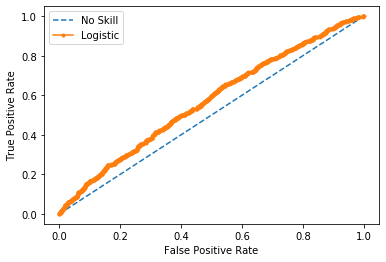

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.571


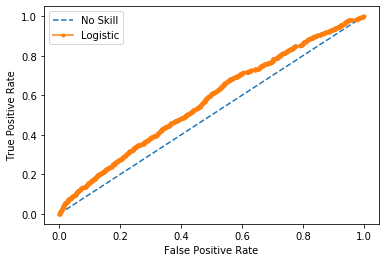

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.582


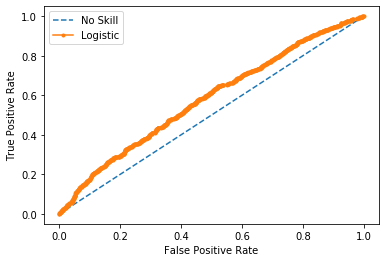

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.575


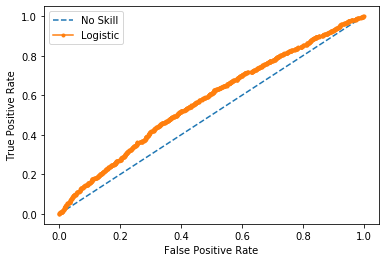

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.583


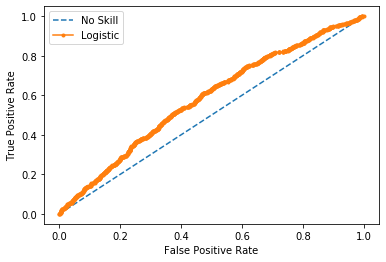

,AUC Train,AUC Test
0,0.968671,0.570124
1,0.966892,0.571256
2,0.966822,0.581509
3,0.967675,0.574816
4,0.971863,0.583381


In [90]:
xgb_model = xgb.XGBClassifier()
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    xgb_model.fit(X_train.iloc[train], y_train.iloc[train])
    y_train_preds = xgb_model.predict_proba(X_train)
    y_preds = xgb_model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_train, y_train_preds[:,1])
    auc_score_train = roc_auc_score(y_train, y_train_preds[:,1])
    fpr, tpr, _ = roc_curve(y_test, y_preds[:,1])
    auc_score = roc_auc_score(y_test, y_preds[:,1])
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    calculate_roc(y_test, y_preds[:,1])
    
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])



In [91]:
scoring = ['precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(xgb_model, X_train, y_train, scoring=scoring)
sorted(scores.keys())

['fit_time',
 'score_time',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro']

In [92]:
scores

{'fit_time': array([3.89271092, 4.22390199, 3.40410519, 3.23154783, 3.87149787]),
 'score_time': array([0.08537912, 0.04067898, 0.04554868, 0.02377152, 0.02746296]),
 'test_precision_macro': array([0.74616848, 0.75802344, 0.77245242, 0.75644316, 0.73929738]),
 'test_recall_macro': array([0.74524313, 0.75565959, 0.77206841, 0.75517467, 0.73720091]),
 'test_f1_macro': array([0.7450035 , 0.75511773, 0.77199563, 0.75485738, 0.73660569])}

In [93]:
print("Recall: %0.2f (+/- %0.2f)" % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std() * 2))

Recall: 0.75 (+/- 0.02)
Precision: 0.75 (+/- 0.02)
F1: 0.75 (+/- 0.02)


## Entrenar y evaluar Modelos

### Regresión Logística

In [11]:
from sklearn.linear_model import LogisticRegression

In [ ]:
LogisticRegression()

In [95]:
logreg = LogisticRegression(penalty='l2',solver='lbfgs',C=0.1,max_iter=10000)

In [96]:
logreg.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [97]:
y_preds = logreg.predict_proba(X_test)

In [98]:
param_grid = { 
    'solver': ['lbfgs', 'liblinear'],
    'C': [0.1,1,10]
}

In [99]:
CV_rfc = GridSearchCV(estimator=logreg, param_grid=param_grid, cv= 2,n_jobs=6, verbose=5)

In [102]:
CV_rfc.get_params()

{'cv': 2,
 'error_score': nan,
 'estimator__C': 0.1,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 10000,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=10000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'iid': 'deprecated',
 'n_jobs': 6,
 'param_grid': {'solver': ['lbfgs', 'liblinear'], 'C': [0.1, 1, 10]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_trai

In [103]:
CV_rfc.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  12 | elapsed:   15.8s remaining:   31.7s
[Parallel(n_jobs=6)]: Done   7 out of  12 | elapsed:   35.8s remaining:   25.6s
[Parallel(n_jobs=6)]: Done  10 out of  12 | elapsed:   38.4s remaining:    7.7s
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:   44.7s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=LogisticRegression(C=0.1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=6,
             param_grid={'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [104]:
CV_rfc.best_estimator_.score(X_test,y_test)

0.5683015808674503

In [105]:
CV_rfc.best_score_

0.5658840947546531

In [106]:
CV_rfc.cv_results_

{'mean_fit_time': array([27.97113872,  4.67943001, 33.2909081 , 11.90122199, 19.02741086,
        11.3838855 ]),
 'std_fit_time': array([1.42649751e+01, 1.02823281e+00, 4.81343269e-03, 3.96762347e+00,
        3.12556922e+00, 2.55886042e+00]),
 'mean_score_time': array([0.00682569, 0.0677681 , 0.01081502, 0.01445293, 0.01080382,
        0.0060674 ]),
 'std_score_time': array([0.00282907, 0.0168941 , 0.00030601, 0.00098276, 0.00017846,
        0.00112712]),
 'param_C': masked_array(data=[0.1, 0.1, 1, 1, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['lbfgs', 'liblinear', 'lbfgs', 'liblinear', 'lbfgs',
                    'liblinear'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1, 'solver': 'lbfgs'},
  {'C': 0.1, 'solver': 'liblinear'},
  {'C': 1, 'solver': 'lbfgs'},
  {'C': 1, 'solver':

In [107]:
print(classification_report(y_test,y_preds[:,1]>0.4))

              precision    recall  f1-score   support

         0.0       0.77      0.10      0.17      1620
         1.0       0.35      0.95      0.51       847

    accuracy                           0.39      2467
   macro avg       0.56      0.52      0.34      2467
weighted avg       0.63      0.39      0.29      2467



In [ ]:
calculate_roc(y_test,y_preds[:,1])

#### Decision Tree

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy',max_depth=6)

In [ ]:
tree.fit(X_train,y_train)

In [ ]:
preds = tree.predict(X_test)
y_preds = tree.predict_proba(X_test)

In [ ]:
print(classification_report(y_test,preds))

In [ ]:
calculate_roc(y_test, y_preds[:,1])


In [ ]:
columnas_entrenamiento = [x for x in df.columns if x != 'target2']

In [ ]:
features = pd.DataFrame(list(zip(columnas_entrenamiento,tree.feature_importances_))).sort_values(by=1,ascending=False)[:10]

In [ ]:
sns.barplot(features.loc[:,0],features.loc[:,1])
plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
tree.get_depth()

### Random Forest

In [ ]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

In [ ]:
rfc

In [ ]:
rfc.fit(X_train, y_train)

In [ ]:
preds=rfc.predict(X_test)
y_preds = rfc.predict_proba(X_test)

In [ ]:
print(classification_report(y_test,y_preds[:,1]>0.35))

In [ ]:
(y_preds[:,1]>0.35).sum()

In [ ]:
calculate_roc(y_test, y_preds[:,1])

In [ ]:
rfc=RandomForestClassifier(n_estimators=1000, max_depth=8, random_state=42)
rfc.fit(X_train, y_train)

In [ ]:
preds=rfc.predict(X_test)
y_preds = rfc.predict_proba(X_test)

In [ ]:
print(classification_report(y_test,preds))

In [ ]:
calculate_roc(y_test, y_preds[:,1])

In [ ]:
xgb_model = xgb.XGBClassifier()
xgbrf_model = xgb.XGBRFClassifier()

In [ ]:
xgb_model.fit(X_train,y_train)

In [ ]:
xgbrf_model.fit(X_train,y_train)

In [ ]:
preds = xgbrf_model.predict(X_test)
y_preds = xgbrf_model.predict_proba(X_test)

In [ ]:
print(classification_report(y_test,y_preds[:,1]>0.30))

In [ ]:
calculate_roc(y_test, y_preds[:,1])

In [ ]:
preds = xgbrf_model.predict(X_test)
y_preds = xgbrf_model.predict_proba(X_test)

In [ ]:
print(classification_report(y_test,preds))

In [ ]:
calculate_roc(y_test, y_preds[:,1])

## Probar con distintos hiperparámetros y con distintos umbrales

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 2,n_jobs=6, verbose=5)

In [ ]:
CV_rfc

In [ ]:
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_score_

In [ ]:
CV_rfc.best_estimator_

In [ ]:
CV_rfc.best_params_

In [ ]:
preds = CV_rfc.predict(X_test)

In [ ]:
print(classification_report(y_test,preds))

### SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
model = SVC(probability=False,kernel='linear')

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict_proba(X_test)

In [ ]:
print(classification_report(y_test, y_pred[:,1]>0.7))

In [ ]:
(y_pred[:,1]>0.4).sum()

In [ ]:
calculate_roc(y_test,y_pred[:,1])